# TO DO

Need to work out the length in the y-direction of the cropped image (without the watermark) so that we can sample from the grid again. Fortunately, x-direction seems to be unchanged.
Also need to change directory references as file structure has changed.

# LIBRARIES USED

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import pandas as pd
import os

# CONSTANTS

In [5]:
## Radius of squares in grid, figured out by mixture of observation and calculation
Y_RAD = 0.00385
X_RAD = 0.0043
N_WARDS = 130

In [6]:
# get the Google Static Maps API key
with open("../google_api_key.txt", "r") as file:
    key = file.readline()

# 1. Get Centers for Images in each Ward

In [7]:
# Opening JSON file of ward shapes
def get_all_ward_shapes(file_name):
    f = open(file_name,) 
    shape_dict = json.load(f)                     # Returns JSON object as a dictionary 
    f.close()
    return shape_dict

In [8]:
## Extracting coordinates for first ward
def get_ward_shape(shape_dict, ward_num):
    coords = shape_dict['features'][ward_num]["geometry"]["coordinates"][0]
    return coords

In [9]:
## Constructing path for ward outline
def coords_to_path(coords):
    path = ""
    for lat, lng in coords:
        path = path + "|" + str(lng) + "," + str(lat)
    return path

In [10]:
## Extracting max and mins for outer bounds of grid
def get_min_max(coords):
    flatten_coords = [item for sublist in coords for item in sublist]   # flattening the nested list
    max_lng = max(flatten_coords[::2])                                  # lngs are even values
    min_lng = min(flatten_coords[::2])
    max_lat = max(flatten_coords[1::2])                                 # lats are odd values
    min_lat = min(flatten_coords[1::2])
    return (max_lat, min_lat, max_lng, min_lng) 

In [11]:
## Extracting all of the centers for the rectangles in the grid
def extract_centers(max_lat, min_lat, max_lng, min_lng):
    center_top_left = (max_lat - Y_RAD, min_lng + X_RAD)    # Center of the top left rectangle in the grid
    center = center_top_left
    center_list = []
    while(center[0] + Y_RAD > min_lat):                     # Loop for changing rows
        row_centers = [center]
        while(center[1] + X_RAD < max_lng):                   # Loop for moving along row
            center = (center[0], center[1] + 2*X_RAD)
            row_centers.append(center)
        center_list.append(row_centers)
        center = (center[0] - 2*Y_RAD, center_top_left[1])
    return center_list

In [14]:
shape_file_dict = get_all_ward_shapes("../shapefile/electoral wards for jhb.json")

In [15]:
df_ward_centers = pd.DataFrame(0, index=np.arange(N_WARDS), columns=["ward_no.", "img_centers"])
df_ward_centers["img_centers"] = df_ward_centers["img_centers"].astype('object') # converting to object to be able to store lists
print(df_ward_centers.dtypes)
df_ward_centers.at[0, 'img_centers'] = [[(1,2), (1,3)]]
df_ward_centers.head()

ward_no.        int64
img_centers    object
dtype: object


,ward_no.,img_centers
0,0,"[[(1, 2), (1, 3)]]"
1,0,0
2,0,0
3,0,0
4,0,0


In [16]:
## Loop this for all wards
for ward_num in range(1, N_WARDS+1):
    coords = get_ward_shape(shape_file_dict, ward_num-1)
    max_lat, min_lat, max_lng, min_lng = get_min_max(coords)
    center_list = extract_centers(max_lat, min_lat, max_lng, min_lng)
    df_ward_centers.at[ward_num-1, 'img_centers'] = center_list
    df_ward_centers.at[ward_num-1, 'ward_no.'] = ward_num

In [38]:
print(df_ward_centers.shape)
df_ward_centers.head()

(130, 2)


,ward_no.,img_centers
0,1,"[[(-26.483020238999927, 27.828767997000057), (..."
1,2,"[[(-26.496054001999937, 27.86212946200004), (-..."
2,3,"[[(-26.47171999699998, 27.854994917000056), (-..."
3,4,"[[(-26.448481038999944, 27.84236260700004), (-..."
4,5,"[[(-26.424091998999927, 27.763540001000024), (..."


In [35]:
# write to csv for safe keeping
df_ward_centers.to_csv('../data/ward_image_centers.csv', index=False)

# 2. Extract Images for each Ward

In [36]:
# read in ward image centers
df_ward_centers = pd.read_csv("../data/ward_image_centers.csv") 
df_ward_centers.head()

,ward_no.,img_centers
0,1,"[[(-26.483020238999927, 27.828767997000057), (..."
1,2,"[[(-26.496054001999937, 27.86212946200004), (-..."
2,3,"[[(-26.47171999699998, 27.854994917000056), (-..."
3,4,"[[(-26.448481038999944, 27.84236260700004), (-..."
4,5,"[[(-26.424091998999927, 27.763540001000024), (..."


In [13]:
def get_imgs(center_str, ward_num, pos, path):
    request_with_ward = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x400&maptype=satellite&format=png&path=fillcolor:0x000000FF|color:0x000000FF|weight:1" + path + "&key=" + key
    request_no_ward = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x400&maptype=satellite&format=png&key=" + key
    # HTTP requests
    response_with_ward = requests.get(request_with_ward)
    response_no_ward = requests.get(request_no_ward)
    
    if not os.path.exists('../images/ward_' + str(ward_num)):
        os.makedirs('../images/ward_' + str(ward_num))
    
    # storing the response in a file (image)
    with open('../images/ward_' + str(ward_num) + "/" + str(pos[0]) + str(pos[1]) + "_with_ward" +'.png', 'wb') as file:
       # writing data into the file
       file.write(response_with_ward.content)

    with open('../images/ward_' + str(ward_num) + "/" + str(pos[0]) + str(pos[1]) +'.png', 'wb') as file:
       # writing data into the file
       file.write(response_no_ward.content)

In [12]:
## Function for converting coordinates to format for Google Static Maps API
def center_to_string(center):
    return str(center[0]) + "," + str(center[1])

In [123]:
# Dowload images from Google Static Maps Api for each ward
# Saved in file ./images/ward_i
# Two imgs from same location: 
## (row,col).png - plain img
## (row,col)_with_ward.png - img with ward overlayed
# (row,col) are matrix coordinates

ward_num = 1    # could use apply or map here
for i, cols in enumerate(df_ward_centers["img_centers"][ward_num-1]):
    coords = get_ward_shape(shape_file_dict, ward_num-1)
    path = coords_to_path(coords)
    for j, row_center in enumerate(cols):
#         get_imgs(center_to_string(row_center), ward_num, (i,j), path)

-26.483020238999927,27.828767997000057


# 3. Edit Images to only Contain Ward Area

In [19]:
# For saving the edited image to ./images/ward_i/edited
def save_edited_img(ward_num, f_no_ward, img):
    # create directory if it doesn't exist
    if not os.path.exists('../images/ward_' + str(ward_num) + '/edited'):
        os.makedirs('../images/ward_' + str(ward_num)+ '/edited')
    
    # writing the image to directory
    cv2.imwrite('../images/ward_' + str(ward_num)+ '/edited/' + f_no_ward, img)

In [20]:
# For setting the area of the img outside of the ward to black
# Edited image saved to ./images/ward_i/edited
def isolate_ward_in_img(ward_num, f_with_ward, f_no_ward):
    img_with_ward = cv2.imread('../images/ward_' + str(ward_num) + '/' + f_with_ward)
    img_no_ward = cv2.imread('../images/ward_' + str(ward_num)+ '/' + f_no_ward)
    
    ## Selecting all non-black pixels from image with ward overlayed (want to remove these)
    pix_out_ward = np.where(np.all(img_with_ward != [0,0,0], axis=-1))
    
    ## Setting all non-black pixels from image without ward overlayed to black
    img_no_ward[pix_out_ward] = [0,0,0]
    img_no_ward[385:,145:,:] = [0,0,0]        # setting bottom-right Google watermark to black
    
    save_edited_img(ward_num, f_no_ward, img_no_ward)

In [21]:
ward_num = 1   # could use apply or map here
directory = os.fsencode("../images/ward_" + str(ward_num))
i = 0
f_with_ward = f_no_ward = ''
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"):
        if i % 2 == 0:
            f_no_ward = filename
        else:
            f_with_ward = filename
            isolate_ward_in_img(1, f_with_ward, f_no_ward)
        i += 1

In [ ]:
'''
Very simple download interface to download images from Google's Static Maps API
'''

class GoogleDownloader:
    def __init__(self, access_token):
        self.access_token = access_token
        self.url = 'https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom={}&size=400x400&maptype=satellite&key={}'
    
    def download(self, lat, long, zoom):
        res = requests.get(self.url.format(lat, long, zoom, self.access_token))
        # server needs to make image available, takes a few seconds
        if res.status_code == 403:
            return 'RETRY'
        assert res.status_code < 400, print(f'Error - failed to download {lat}, {long}, {zoom}')
        image = plt.imread(BytesIO(res.content))
        return image

## Illustration of editing

In [22]:
img_with_ward = cv2.imread("../images/ward_1/00_with_ward.png")
img_no_ward = cv2.imread("../images/ward_1/00.png")
print(img_with_ward.shape)
print(img_no_ward.shape)

(400, 400, 3)
(400, 400, 3)


In [23]:
def plot_fig(img):
    img_matplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_matplot)

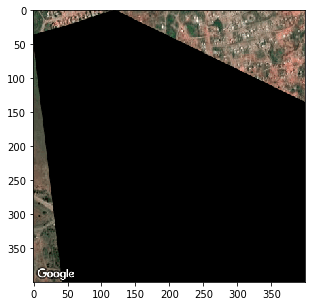

In [24]:
plot_fig(img_with_ward)

In [25]:
## All pixels that aren't black
pix_out_ward = np.where(np.all(img_with_ward != [0,0,0], axis=-1))

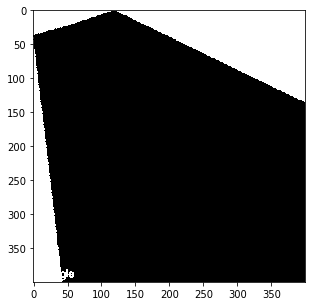

In [26]:
## Setting all non-black pixels to white
img_with_ward[pix_out_ward] = [255,255,255]
plot_fig(img_with_ward)

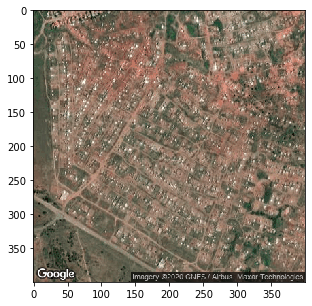

In [27]:
plot_fig(img_no_ward)

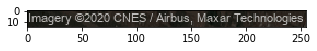

In [28]:
plot_fig(img_no_ward[385:,145:,:]) # isolating band at bottom

In [29]:
img_no_ward[pix_out_ward] = [0,0,0]               # setting all non-black pixels from other image to black in this image
img_no_ward[385:,145:,:] = [0,0,0]                # setting bottom-right Google watermark to black

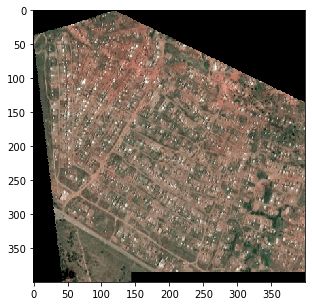

In [30]:
plot_fig(img_no_ward)

# Removing Google Watermarks

In [133]:
# Need to load a larger image so that we can crop to 400x400
center_str = '-26.483020238999927,27.828767997000057'
request_no_ward = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x425&maptype=satellite&format=png&key=" + key
# HTTP requests
response_no_ward = requests.get(request_no_ward)
    
# storing the response in a file (image)

with open('../test.png', 'wb') as file:
   # writing data into the file
   file.write(response_no_ward.content)

In [134]:
img_with_ward = cv2.imread("../test.png")
img_no_ward = cv2.imread("../images/ward_1/00.png")
print(img_with_ward.shape)
print(img_no_ward.shape)

(425, 400, 3)
(400, 400, 3)


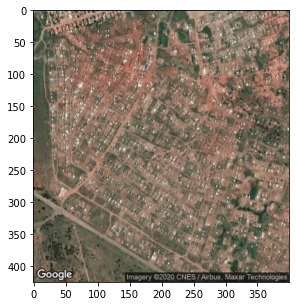

In [135]:
plot_fig(img_with_ward)

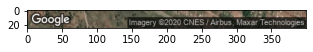

In [136]:
plot_fig(img_with_ward[400:,:,:])

(400, 400, 3)


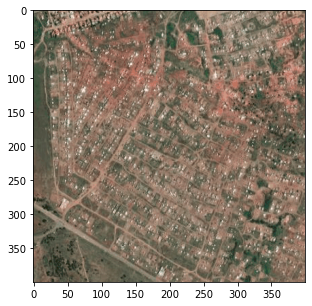

In [138]:
plot_fig(img_with_ward[0:400,:,:])    # removing Google Watermarks
print(img_with_ward[0:400,:,:].shape) # check the shape

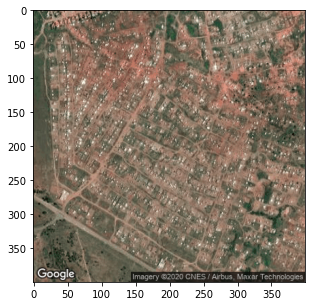

In [139]:
plot_fig(img_no_ward)
# The area at top of image has increase as well. 
# Problem! Need to work out new length in y direction